<a id='frontmatter'></a>

# Welcome to `emdfile`!


<hr style="border:2px solid gray">

File I/O - that is "input/output", comprising reading and writing files and the whole hairy mess of fileformats - is a pain.  The point of ``emdfile`` is to make it easy.

For small bits of code doing little tasks, there's no need to think about I/O.  In these halcyon days ("Then", below) we can write some Python, run it, and get whatever output we need - perhaps some visualization that helps us learn or understand something better.  For any more complicated computation - if our code takes more than a few moments to run, say, or if we want to chain several analyses together and don't want to run everything again with each change - it becomes important to save and later reload information ("Now").


<img src="./pngs/UseCase_v2.png" alt="Use Case" width="500"/>


The example that follows shows the evolution of a "Then" to a "Now" analysis, and will hopefully convince you that ``emdfile`` is a useful tool to quickly and easily make that change.



## Contents 

- Ch. 1: [Make some sample data](#generatedata)
- Ch. 2: [Initial analysis ("Then")](#1stpass)
- Ch. 3: [Refactor into a class](#class)
- Ch. 4: [Add read/write with ``emdfile``](#io)
- Ch. 5: [Scale anaylsis ("Now")](#manydatasets)



## See also

- [The emdfile documentation pages](https://emdfile.readthedocs.io/en/latest/)
- [Jupyter - Basic examples and usage](https://github.com/py4dstem/emdfile/blob/main/samplecode/basic_usage.ipynb)
- [Jupyter - Detailed walk through package functionality](https://github.com/py4dstem/emdfile/blob/main/samplecode/functionality_walkthrough.ipynb)


 <a id='generatedata'></a>

# Generate Data

Here we make a class which will generate data for us, then use it to make some data.

The data will be a 3D stack of 2D images of noisy Gaussian distributions moving at a constant velocity between frames.

In [2]:
# Generate data

# This cell defines a class that makes datasets
# our data will be 3D arrays comprised of 8 frames of 256x256 images, each
# containing a gaussian blob which moves at a constant velocity between frames

shape = (256,256,8)
import numpy as np
from scipy.stats import poisson

class DataGenerator:
    """ This class generates data by
            (1) initializing some starting position `xy0` and velocity `v0`
            (2) finding the position at each of 8 time points
            (3) at each of these 8 time points, place a 2D Gaussian into a 256x256 grid
            (4) generate a 256x256 image at each time point by drawing from a Poisson
                distribution, using an expected value given at each pixel by the Gaussian
    """
    params = {'A':5, 'sigx':12, 'sigy':9}  # 2D gaussian parameters
    mu_scale = 1                           # scaling for Poisson draws
    
    def __init__(self, xy0, v0):
        """ 2-tuples xy0 and v0"""
        # set the initial position and velocity
        self.xy0 = np.array(xy0)
        self.v0 = np.array(v0)

        # find the center at each time point
        self.xy = self.xy0[:,np.newaxis] + \
            np.tile(np.arange(8),(2,1))*self.v0[:,np.newaxis]
        
        # make the data
        self.generate_data()


    def generate_data(self):
        """ make a 2D gaussian on a grid, then draw from a Poisson distribution using
            an expected value given at each pixel by the Gaussian
        """
        # make a meshgrid
        yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
        self.xx,self.yy = xx-shape[0]/2., yy - shape[1]/2.
        
        # extend in the third dimension and center
        self.xx = np.dstack([ self.xx[:,:,np.newaxis] - x for x in self.xy[0,:] ])
        self.yy = np.dstack([ self.yy[:,:,np.newaxis] - y for y in self.xy[1,:] ])
        
        # get the data       
        self.data = poisson.rvs(
            self.gaussian((self.xx,self.yy), **(DataGenerator.params)) * DataGenerator.mu_scale
        )
    
    @staticmethod
    def gaussian(p,A,sigx,sigy):
        return A * np.exp(-(0.5*(p[0]/sigx)**2)) * np.exp(-(0.5*(p[1]/sigy)**2))
    
# generate some data
xy0 = (-17,-9)
v0 = (6,8)
data_generator = DataGenerator(xy0, v0)

In [3]:
print(data_generator)

In [4]:
print(data_generator.data.shape)

(256, 256, 8)


 <a id='1stpass'></a>

# "Then": initial analysis

In initial analysis we'll visualize the data a few ways, then find and show the center of mass of each image.

In [5]:
# Visualization utilities
# A function to show one image and a fn to show several

import matplotlib.pyplot as plt

def show_im(im,xy=None):
    """ Show one image, `im`.  If `xy` is passed it specifies one or more points,
        which are overlaid in red
    """
    fig,ax = plt.subplots()
    ax.matshow(im,cmap='gray',vmin=0,vmax=0.5*np.max(im))
    if xy is not None:
        ax.scatter(xy[1],xy[0],color='r',s=16)
    plt.show()
    
def show_ims(ims,xys=None):
    """ Show all 8 images, `ims`.  If `xys` is passed it specifies a point for each image,
        which are overlaid in red
    """
    fig,axs = plt.subplots(2,4,figsize=(12,6))
    for idx in range(8):
        im = ims[:,:,idx]
        ax = axs[idx//4,idx%4]
        ax.matshow(im,cmap='gray',vmin=0,vmax=0.5*np.max(im))
        if xys is not None:
            ax.scatter(xys[1,idx],xys[0,idx],color='r',s=16)
    plt.show()

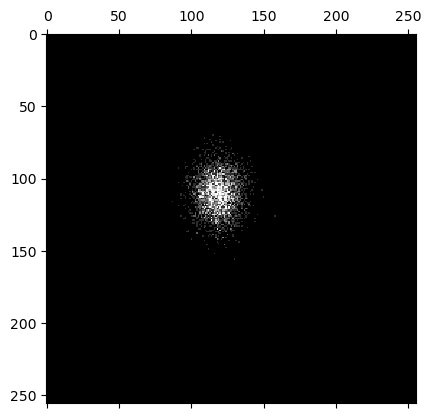

In [6]:
# Show one image from the 8 image dataset

show_im(data_generator.data[:,:,0])

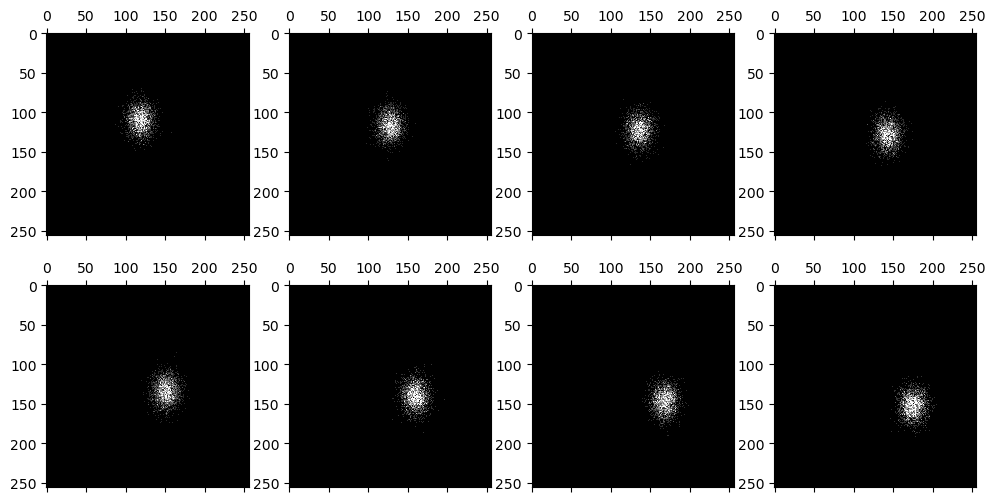

In [7]:
# Show all 8 images

show_ims(data_generator.data)

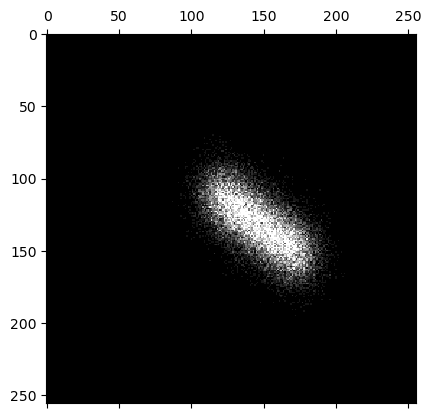

In [8]:
# Find and show the mean of all images

show_im(np.mean(data_generator.data,axis=2))

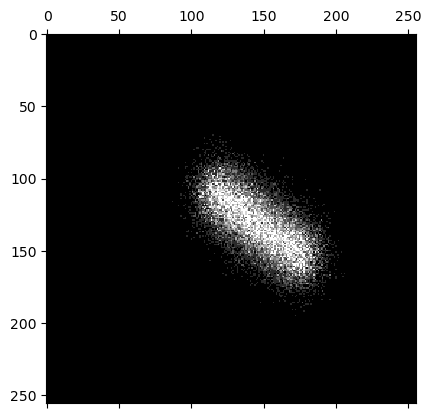

In [9]:
# Find and show the maximum of all images

show_im(np.max(data_generator.data,axis=2))

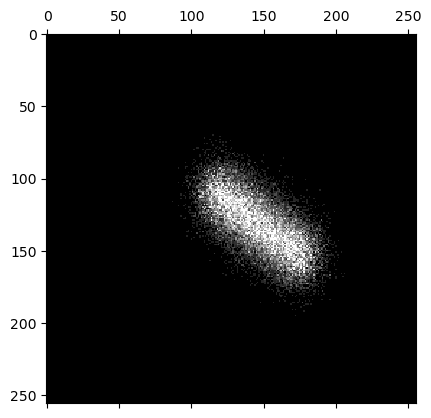

In [10]:
# Find and show the standard deviation of all images

show_im(np.std(data_generator.data,axis=2))

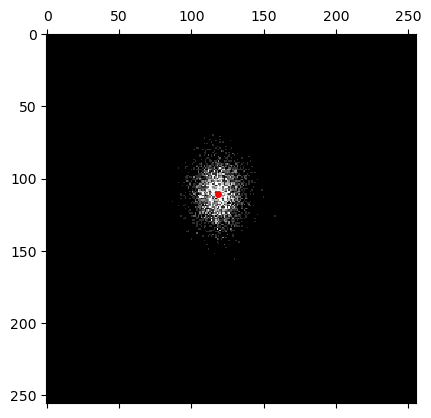

In [11]:
# Find and show the center of mass of all the images

def get_com(im):
    tot = np.sum(im)
    yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
    return (np.sum(xx*im)/tot, np.sum(yy*im)/tot)

# compute one c.o.m.
com = get_com(data_generator.data[:,:,0])

# show
show_im(data_generator.data[:,:,0],com)

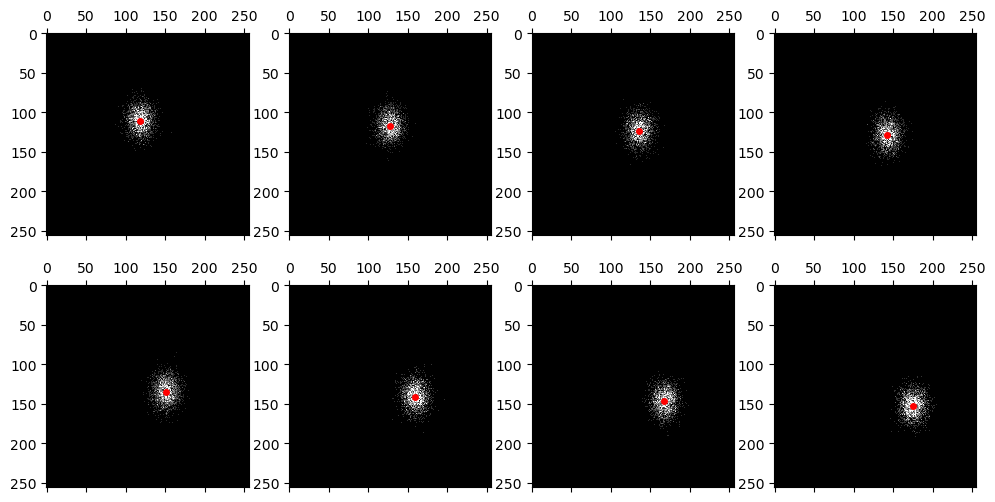

In [12]:
# get all coms and show

coms = np.array([get_com(data_generator.data[:,:,i]) for i in range(shape[2])]).T

show_ims(data_generator.data,coms)

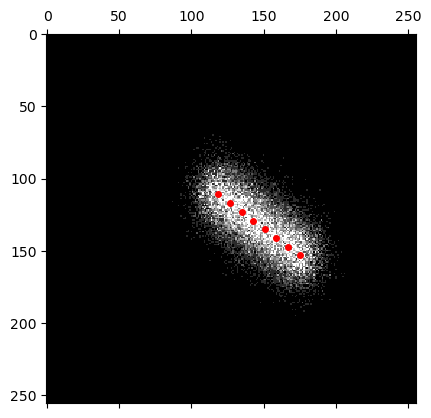

In [13]:
# Show coms over the max image

show_im(
    np.max(data_generator.data,axis=2),
    coms,
)

 <a id='class'></a>


# Refactor into a class

The code in the last section got the job done, but is unstructured.  Here we'll add some structure by making a class which can do the whole workflow.

In [14]:
# Define the analysis class

class ScientificAnalysis:
    """
    Analysis for a very important investigation into
    the apparent motion of fuzzy looking blobs
    """
    
    def __init__(self, data):
        """ `data` should be a (256,256,8) shaped array
        """
        self.data = data

        
    # analysis methods
        
    def get_max(self):
        self.max = np.max(self.data,axis=2)
    def get_mean(self):
        self.mean = np.mean(self.data,axis=2)
    def get_std(self):
        self.std = np.std(self.data,axis=2)
    
    @staticmethod
    def get_com(im):
        tot = np.sum(im)
        yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))  # for many datasets, this won't be terribly efficient :p
        return (np.sum(xx*im)/tot, np.sum(yy*im)/tot)
    
    def get_coms(self):
        self.coms = np.array([get_com(self.data[:,:,i]) for i in range(shape[2])]).T

In [15]:
# Perform analysis

# instantiate a class instance
my_analysis = ScientificAnalysis( data=data_generator.data )

# analyze
my_analysis.get_max()
my_analysis.get_mean()
my_analysis.get_std()
my_analysis.get_coms()

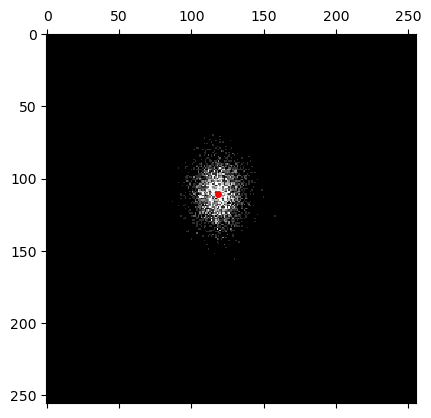

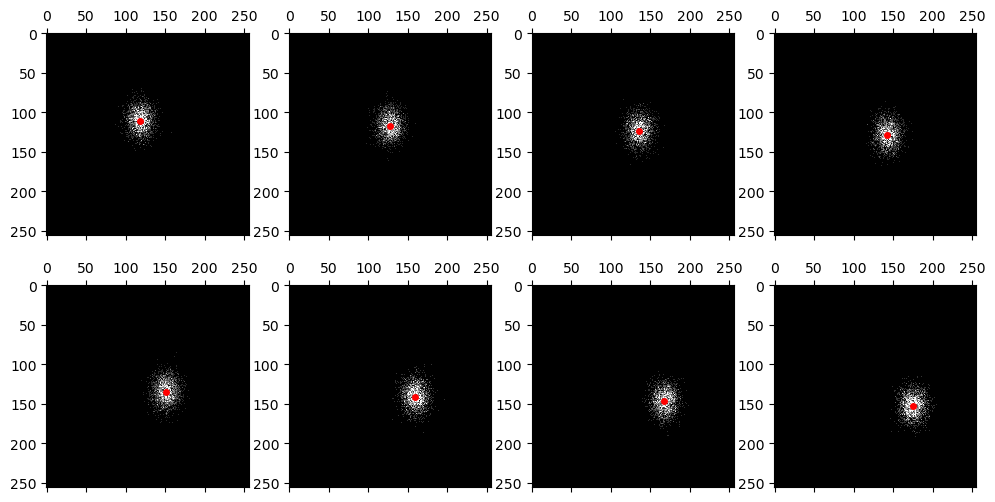

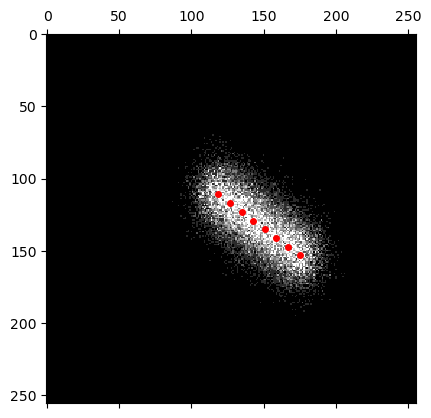

In [16]:
# The visualization are they're the same, with very slightly modified syntax

show_im(
    my_analysis.data[:,:,0],
    coms[:,0])
show_ims(
    my_analysis.data,
    coms)
show_im(
    my_analysis.max,
    coms)

<a id='io'></a>

# Add read/write with ``emdfile``

Now we'll add in ``emdfile``.  With minimal new code, our workflow can be saved and loaded again later.

In [17]:
# set the filepath
# modify to point somewhere on your filesystem

filepath = "/Users/Ben_1/Desktop/test.h5"

In [18]:
# Extend analysis class to support i/o

import emdfile as emd

class VeryScientificAnalysis:
    """
    Analysis for a very important investigation into
    the apparent motion of fuzzy looking blobs.

    ** changelog **
        current version can save outputs
        and read them again later
        (`pip install emdfile`)
    """
    def __init__(self, data):
        """"""
        self.data = data
        
    # analysis methods
    def get_max(self):
        self.max = np.max(self.data,axis=2)
    def get_mean(self):
        self.mean = np.mean(self.data,axis=2)
    def get_std(self):
        self.std = np.std(self.data,axis=2)
    @staticmethod
    def get_com(im):
        tot = np.sum(im)
        yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
        return (np.sum(xx*im)/tot, np.sum(yy*im)/tot)
    def get_coms(self):
        self.coms = np.array([self.get_com(self.data[:,:,i]) for i in range(shape[2])]).T
    
    # save
    def save(self,filepath):
        """ Save the data. """
        # wrap the data in emd classes,
        # giving each a descriptive name
        ar_max = emd.Array( data=self.max, name='max')
        ar_mean = emd.Array( data=self.mean, name='mean')
        ar_std = emd.Array( data=self.std, name='std' )
        ar_coms = emd.Array( data=self.coms, name='coms' )
        
        # write the file
        emd.save(filepath, [
            ar_max,
            ar_mean,
            ar_std,
            ar_coms
            ],
            mode = 'o'   # ** see note below
        )

#### End Class ####

#### Note
The line `mode = 'o'` tells `emdfile` to use "overwrite" mode - that is, if a file already exists at this
location, delete it and write a new file. Use at your own risk. If overwrite mode is not specified and there's already a file at the given path, `emdfile` will throw an error.

In [19]:
# Run the workflow

# Instantiate class
my_analysis = VeryScientificAnalysis( data=data_generator.data )

# Analyze data
my_analysis.get_max()
my_analysis.get_mean()
my_analysis.get_std()
my_analysis.get_coms()

# Save outputs
my_analysis.save(filepath)

In [20]:
# We can look at the contents of the file without loading anything

emd.print_h5_tree(filepath)

/
|---root_savedlist
    |---coms
    |---max
    |---mean
    |---std




In [21]:
# And we can load the data

loaded_data = emd.read(filepath)

In [22]:
# In the EMD 1.0 format, each HDF5 file can contain any number of directory-like trees
# (in this case, our file only stores one). `loaded_data` is a `Root` type object because
# we've loaded an entire EMD tree, which we can now access starting from it's root

loaded_data

Root( A Node called 'root_savedlist', containing the following top-level objects in its tree:

          coms                     	 (Array)
          max                      	 (Array)
          mean                     	 (Array)
          std                      	 (Array)
)

In [23]:
# Inspect the contents of the EMD tree

loaded_data.tree()

/
|---coms
|---max
|---mean
|---std


In [24]:
# Access the data

ar_max = loaded_data.tree('max')
ar_mean = loaded_data.tree('mean')
ar_std = loaded_data.tree('std')
ar_coms = loaded_data.tree('coms')

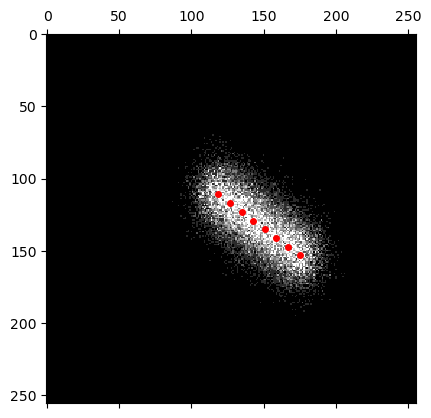

In [25]:
# Visualize

show_im(
    ar_max.data,
    ar_coms.data
)

In [26]:
# Notice that the data itself are no longer numpy ndarrays - they are emd Arrays.

ar_mean

Array( A 2-dimensional array of shape (256, 256) called 'mean',
       with dimensions:

           dim0 = [0,1,2,...] pixels
           dim1 = [0,1,2,...] pixels
)

In [27]:
# with the data itself accessible in the .data attribute

ar_mean.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<a id='manydatasets'></a>

# "Now" : Scale anaylsis

Now imaging we have 100 different 3D stacks representing 100 different experimental observations of fuzzy blobs on the move.  Perhaps we want to know if they have any statistical direction preference.

Here we 
- modify our analysis class slightly, to save many analyses to a single file,
- generate 100 datasets, then run the workflow on all of them, and
- load from all the outputs, then make a histogram of blob velocity directions.

In [28]:
# Delete the file from the previous section

from os.path import exists
from os import remove
if exists(filepath):
    remove(filepath)

In [29]:
# Extend analysis class to write many analyses to a single file
# only a few additional lines of code are needed

class ExtremelyScientificAnalysis:
    """
    Analysis for a very important investigation into
    the apparent motion of fuzzy looking blobs.

    ** changelog **
        current version can save outputs
        from many experimental runs to
        a single file
    
        current version can save outputs
        and read them again later
        (`pip install emdfile`)
    """
    def __init__(self, name, data):
        """"""
        self.name = name        # add a name as an identifier for each analysis
        self.data = data
        
    # analysis methods      
    def get_max(self):
        self.max = np.max(self.data,axis=2)
    def get_mean(self):
        self.mean = np.mean(self.data,axis=2)
    def get_std(self):
        self.std = np.std(self.data,axis=2)
    @staticmethod
    def get_com(im):
        tot = np.sum(im)
        yy,xx = np.meshgrid(np.arange(shape[1]),np.arange(shape[0]))
        return (np.sum(xx*im)/tot, np.sum(yy*im)/tot)
    def get_coms(self):
        self.coms = np.array([self.get_com(self.data[:,:,i]) for i in range(shape[2])]).T

    # save    
    def save(self,filepath):
        """ Save the data, writing a new file if the specified filepath doesn't exist,
            or if it does, appending the data to the existing file
        """
        # wrap the data in emd classes,
        # giving each a descriptive name
        ar_max = emd.Array( data=self.max, name='max')
        ar_mean = emd.Array( data=self.mean, name='mean')
        ar_std = emd.Array( data=self.std, name='std' )
        ar_coms = emd.Array( data=self.coms, name='coms' )

        # make an EMD tree
        root = emd.Root( name=self.name )
        root.tree( ar_max )
        root.tree( ar_mean )
        root.tree( ar_std )
        root.tree( ar_coms )
                 
        # if a file doesn't exist at this location, write a new file.
        # if a file already exists, append new data to it
        if not exists(filepath):
            emd.save(filepath, root)        
        else:
            emd.save(filepath, root, mode = 'a')

#### End Class ####

In [30]:
# Generate 100 datasets
# Let's say our blobs *do* have some orientational preference...

from scipy.stats import uniform,cosine

# set the velocities
centers = uniform.rvs(-10,20,size=(2,100))  # uniform distribution from -10 to 10
vmag = uniform.rvs(0,10,size=100)           # uniform distribution from 0 to 10
vang = cosine.rvs(0,np.pi/4,size=100)       # cosine distribution from -pi/2 to pi/2
velocities = np.vstack(
    [vmag*np.sin(vang),
     vmag*np.cos(vang)])

# build the datasets
datasets = []
for idx in range(100):    
    datasets.append( DataGenerator(centers[:,idx], velocities[:,idx]) )

In [31]:
# Analyze

for idx in range(100):
    
    # instantiate
    analysis = ExtremelyScientificAnalysis(
        name = f'experiment_{idx}',
        data = datasets[idx].data
    )

    # analyze
    analysis.get_max()
    analysis.get_mean()
    analysis.get_std()
    analysis.get_coms()
    
    # and save
    analysis.save(filepath)

In [32]:
# Show our processing data file
# The tree is a bit large...

emd.print_h5_tree(filepath)

/
|---experiment_0
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_1
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_10
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_11
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_12
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_13
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_14
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_15
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_16
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_17
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_18
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_19
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_2
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_20
|   |---coms
|   |---max
|   |---mean
|   |---std
|---experiment_21
|   |---coms
|   |---max
|   |-

In [33]:
# Later we can come back and load the data.

# Because this file contains many EMD trees,
# passing its path to the read function without specifying which
# will return a list of all the trees present

loaded_data = emd.read(filepath)
print()
print(loaded_data)

Multiple root groups detected - please specify the `emdpath` argument. Returning a list of root group names.

['experiment_0', 'experiment_1', 'experiment_10', 'experiment_11', 'experiment_12', 'experiment_13', 'experiment_14', 'experiment_15', 'experiment_16', 'experiment_17', 'experiment_18', 'experiment_19', 'experiment_2', 'experiment_20', 'experiment_21', 'experiment_22', 'experiment_23', 'experiment_24', 'experiment_25', 'experiment_26', 'experiment_27', 'experiment_28', 'experiment_29', 'experiment_3', 'experiment_30', 'experiment_31', 'experiment_32', 'experiment_33', 'experiment_34', 'experiment_35', 'experiment_36', 'experiment_37', 'experiment_38', 'experiment_39', 'experiment_4', 'experiment_40', 'experiment_41', 'experiment_42', 'experiment_43', 'experiment_44', 'experiment_45', 'experiment_46', 'experiment_47', 'experiment_48', 'experiment_49', 'experiment_5', 'experiment_50', 'experiment_51', 'experiment_52', 'experiment_53', 'experiment_54', 'experiment_55', 'experiment

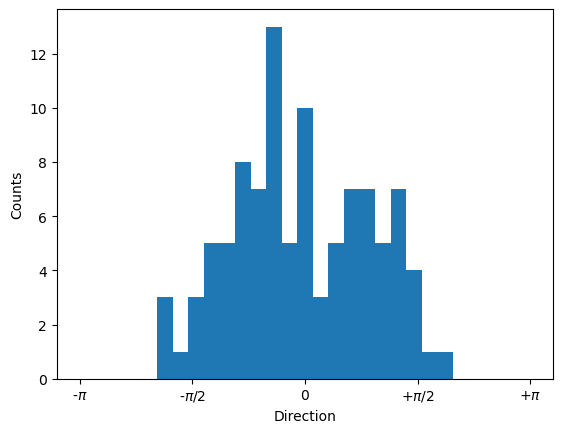

In [34]:
# We didn't find the velocities in our previous analysis,
# but we *did* find the centers of the blobs in each frame.
# Now we'll load those center positions, compute the velocities,
# and then visualize the directions of motion with a histogram.

orientations = np.empty(100)

for idx,rootname in enumerate(loaded_data):         # loop through all the experiments
    root = emd.read(filepath, emdpath=rootname)     # load the EMD tree from an experiment
    coms = root.tree('coms')                        # get the centers of mass
    v_mean = coms[:,-1] - coms[:,0]                 # find the velocity
    orientations[idx] = np.angle(-1j*v_mean[0]+v_mean[1])     # find the direction
    
# plot a histogram
fig,ax = plt.subplots()
ax.hist(orientations, bins=np.linspace(-np.pi,np.pi,30))
ax.set_xticks(np.linspace(-np.pi,np.pi,5))
ax.set_xticklabels([r'-$\pi$',r'-$\pi/2$',r'0',r'+$\pi/2$',r'$+\pi$'])
ax.set_xlabel('Direction')
ax.set_ylabel('Counts')
plt.show()